# **Acute Ischemic Stroke Segmentation**

## Integrantes
---
- Laura Rodriguez Cala
- Gysselis Vásquez Garcés
- Oscar Andrés Ramírez Serna


## Descripción del proyecto
---
El diagnóstico y tratamiento oportuno de las lesiones de ACV isquémico requiere una segmentación manual precisa, pero esta tarea es ineficiente y subjetiva. Por eso, el objetivo de este proyecto es crear un método automatizado para segmentar las lesiones de ACV isquémico agudo (AIS) en las imágenes de ADC y NCCT. El problema que se soluciona es la detección temprana y exacta de estas lesiones, que pueden provocar daños neurológicos y discapacidad. Para ello, se usan técnicas de Deep learning y procesamiento de imágenes, con las marcaciones de expertos como ground truth. Se busca obtener un algoritmo que identifique y delimite las áreas afectadas por el AIS, con alta sensibilidad y especificidad, y que funcione con diferentes tipos de imágenes.

## Descripción del dataset
---
Este proyecto se basa en un conjunto de datos privado del grupo BIVL2ab, que contiene imágenes capturadas a pacientes con ACV isquémico en las primeras 24 horas tras los síntomas. Las imágenes son de las modalidades DWI, ADC y NCCT, y están pareadas con las marcaciones de las lesiones hechas por expertos. El conjunto de datos se divide en:
- Train: 60 pacientes
- Test: 38 pacientes

---

In [1]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


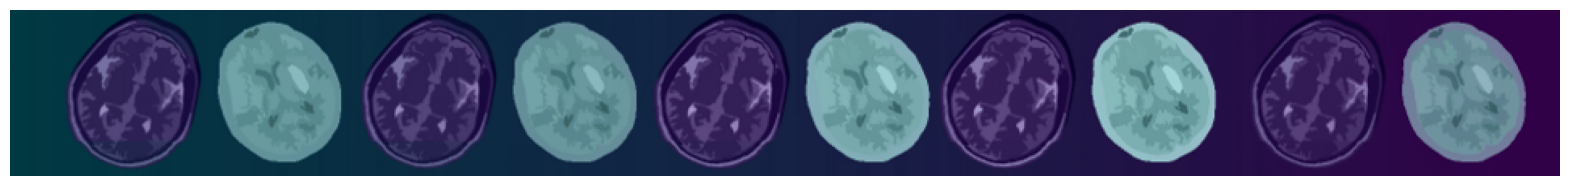

In [ ]:
#@title Banner
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen
ruta_imagen = '/content/drive/MyDrive/Project-IA2/Imagen1.png'

# Cargar la imagen
imagen = mpimg.imread(ruta_imagen)

plt.figure(figsize=(20, 16))

# Plotear la imagen
plt.imshow(imagen)
plt.axis('off')
plt.show()


In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import keras.backend as K
from keras.layers import Flatten
from tensorflow.keras import activations
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, ReLU, Add, Dropout, Concatenate
from keras.layers import concatenate, add
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from PIL import Image
import cv2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
import nibabel as nib
from pathlib import Path
from typing import List, Union
from tqdm.notebook import tqdm
from keras.losses import binary_crossentropy
import zipfile


In [3]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)

    return iou

def metricas(y_val,preds_val_t):
    dice = f1_score(y_val.flatten(), preds_val_t.flatten(), pos_label=1 )
    acc = accuracy_score(y_val.flatten(), preds_val_t.flatten())
    iou = calculate_iou(y_val.flatten(), preds_val_t.flatten())
    print("Accuracy:",acc,"\nDice Score:", dice, "\nIoU:", iou)
    return dice, acc, iou

### Descargar el dataset

In [ ]:
zip_file_path = '/content/drive/MyDrive/Project-IA2/APIS.zip'
extract_path = '/content/drive/MyDrive/Project-IA2'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# **PARTE 1: SEGMENTACIÓN EN MODALIDAD ADC**

## **Cargar datos de train ADC**

In [4]:
dataset_dir = Path("/content/drive/MyDrive/Project-IA2/APIS/train")
patients_dirs = sorted(dataset_dir.iterdir())

In [5]:
epsilon = 1e-5
Xtrain=[]
Ytrain=[]

for patient_dir in tqdm(patients_dirs[0:]):
    patient_id = patient_dir.name
    print("Paciente: ",patient_id)
    content = sorted(patient_dir.iterdir())

    masks_dir = patient_dir / "masks" / f"{patient_id}_r1_mask.nii.gz"
    adc_dir = patient_dir / f"{patient_id}_adc.nii.gz"

    adc = nib.load(adc_dir)
    mask = nib.load(masks_dir)

    adc = adc.get_fdata()
    mask = mask.get_fdata()
    adc = tf.image.resize(adc, (256, 256), method="nearest")
    mask = tf.image.resize(mask, (256, 256), method="nearest")

    for i in range(2,adc.shape[2]):
        normalized_adc = (adc[:,:,i]-np.min(adc[:,:,i]))/(np.max(adc[:,:,i]) - np.min(adc[:,:,i]) + epsilon)
        Xtrain.append(normalized_adc)
    print("Shape ADC: ", adc.shape)


    for i in range(2,adc.shape[2]):
        Ytrain.append((mask[:,:,i]))
    print("Shape máscara: ", mask.shape)
    print("--------------------")

  0%|          | 0/60 [00:00<?, ?it/s]

Paciente:  train_000
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_001
Shape ADC:  (256, 256, 23)
Shape máscara:  (256, 256, 23)
--------------------
Paciente:  train_002
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_003
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_004
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  train_005
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  train_006
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_007
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_008
Shape ADC:  (256, 256, 20)
Shape máscara:  (256, 256, 20)
--------------------
Paciente:  train_009
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------


In [6]:
Xtrain = np.array(Xtrain)
Xtrain = Xtrain.reshape(-1, 256, 256, 1)
Ytrain = np.array(Ytrain)
print(Xtrain.shape)

(1361, 256, 256, 1)


## **Cargar datos de test ADC**

In [7]:
dataset_dir = Path("/content/drive/MyDrive/Project-IA2/APIS/test")
patients_dirs = sorted(dataset_dir.iterdir())

In [8]:
Xtest = []
Ytest = []
epsilon = 1e-5

for patient_dir in tqdm(patients_dirs[0:]):
    patient_id = patient_dir.name
    print("Paciente: ", patient_id)
    content = sorted(patient_dir.iterdir())

    masks_dir = next(patient_dir.joinpath("masks").glob("*.nii.gz"))
    adc_dir = patient_dir / f"{patient_id}_adc.nii.gz"

    adc = nib.load(adc_dir)
    mask = nib.load(masks_dir)

    adc = adc.get_fdata()
    mask = mask.get_fdata()
    adc = tf.image.resize(adc, (256, 256), method="nearest")
    mask = tf.image.resize(mask, (256, 256), method="nearest")

    for i in range(2, adc.shape[2]):
        normalized_adc = (adc[:,:,i]-np.min(adc[:,:,i]))/(np.max(adc[:,:,i]) - np.min(adc[:,:,i]) + epsilon)
        Xtest.append(normalized_adc)
    print("Shape ADC: ", adc.shape)

    for i in range(2, adc.shape[2]):
        Ytest.append((mask[:, :, i]))
    print("Shape máscara: ", mask.shape)
    print("--------------------")

  0%|          | 0/38 [00:00<?, ?it/s]

Paciente:  test_000
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_001
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_002
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_003
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_004
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_005
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_006
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_007
Shape ADC:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_008
Shape ADC:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_009
Shape ADC:  (256, 256, 23)
Shape máscara:  (256, 256, 23)
--------------------
Paciente: 

In [9]:
Xtest = np.array(Xtest)
Xtest = Xtest.reshape(-1, 256, 256, 1)
Ytest = np.array(Ytest)
print(Xtest.shape)

(873, 256, 256, 1)


## **Plotear algunas imágenes ADC**

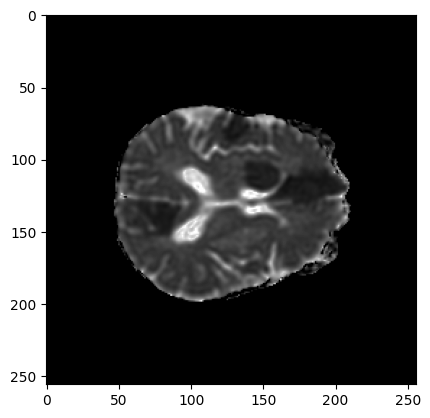

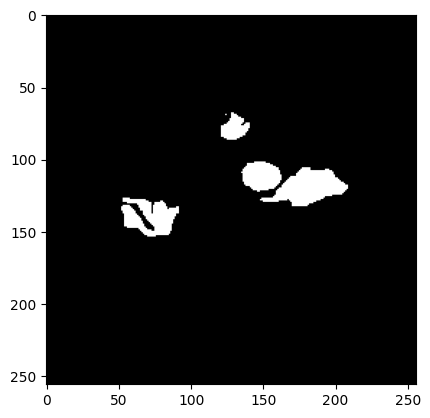

In [10]:
plt.imshow(Xtest[862], cmap="gray")
plt.show(); plt.close()
plt.imshow(Ytest[862], cmap="gray")
plt.show(); plt.close()

## **INFORMACIÓN EXTRA**

## **Números de slices con y sin lesión para Train**

In [13]:
# Función para verificar si una máscara tiene lesiones
def tiene_lesiones(mask):
    return not np.all(mask == 0)

# Contadores para lesiones y no lesiones
lesiones_count = 0
no_lesiones_count = 0

# Recorrer todas las máscaras en Ytrain
for mask in Ytrain:
    if tiene_lesiones(mask):
        lesiones_count += 1
    else:
        no_lesiones_count += 1

print(f"Número de máscaras con lesiones: {lesiones_count}")
print(f"Número de máscaras sin lesiones: {no_lesiones_count}")


Número de máscaras con lesiones: 258
Número de máscaras sin lesiones: 1103


## **Número de slices con y sin lesión para Test**

In [14]:
# Función para verificar si una máscara tiene lesiones
def tiene_lesiones(mask):
    return not np.all(mask == 0)

# Contadores para lesiones y no lesiones
lesiones_count = 0
no_lesiones_count = 0

# Recorrer todas las máscaras en Ytest
for mask in Ytest:
    if tiene_lesiones(mask):
        lesiones_count += 1
    else:
        no_lesiones_count += 1

print(f"Número de máscaras con lesiones: {lesiones_count}")
print(f"Número de máscaras sin lesiones: {no_lesiones_count}")

Número de máscaras con lesiones: 211
Número de máscaras sin lesiones: 662


## **Construir bloque convolucional**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # First layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

## **Función de pérdida BCE + Dice Loss**

In [ ]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

## **Construyendo modelo U-Net**

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## **Compilando el modelo**

In [ ]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss=bce_dice_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         640       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 64)         256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 256, 256, 64)         0         ['batch_normalization_1[0]

## **Entramiento del modelo con ADC**

In [ ]:
results = model.fit(Xtrain, Ytrain, batch_size=32, epochs=50, shuffle=False, validation_split=0.1)

Epoch 1/50
39/39 [==============================] - 75s 2s/step - loss: 1.1393 - val_loss: 1.7061
Epoch 2/50
39/39 [==============================] - 69s 2s/step - loss: 1.0302 - val_loss: 1.2447
Epoch 3/50
39/39 [==============================] - 69s 2s/step - loss: 1.0042 - val_loss: 1.6391
Epoch 4/50
39/39 [==============================] - 69s 2s/step - loss: 0.9696 - val_loss: 3.5682
Epoch 5/50
39/39 [==============================] - 69s 2s/step - loss: 0.9170 - val_loss: 5.2942
Epoch 6/50
39/39 [==============================] - 69s 2s/step - loss: 0.8588 - val_loss: 1.4307
Epoch 7/50
39/39 [==============================] - 68s 2s/step - loss: 0.8132 - val_loss: 1.6239
Epoch 8/50
39/39 [==============================] - 69s 2s/step - loss: 0.7181 - val_loss: 0.9223
Epoch 9/50
39/39 [==============================] - 68s 2s/step - loss: 0.7875 - val_loss: 1.1013
Epoch 10/50
39/39 [==============================] - 69s 2s/step - loss: 0.7623 - val_loss: 0.8790
Epoch 11/50
39/39 [

In [ ]:
preds_train = model.predict(Xtrain, verbose=1)
preds_val = model.predict(Xtest, verbose=1)

preds_val.shape, preds_train.shape

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

28/28 [==============================] - 11s 395ms/step


## **Visualizando las predicciones para ADC**

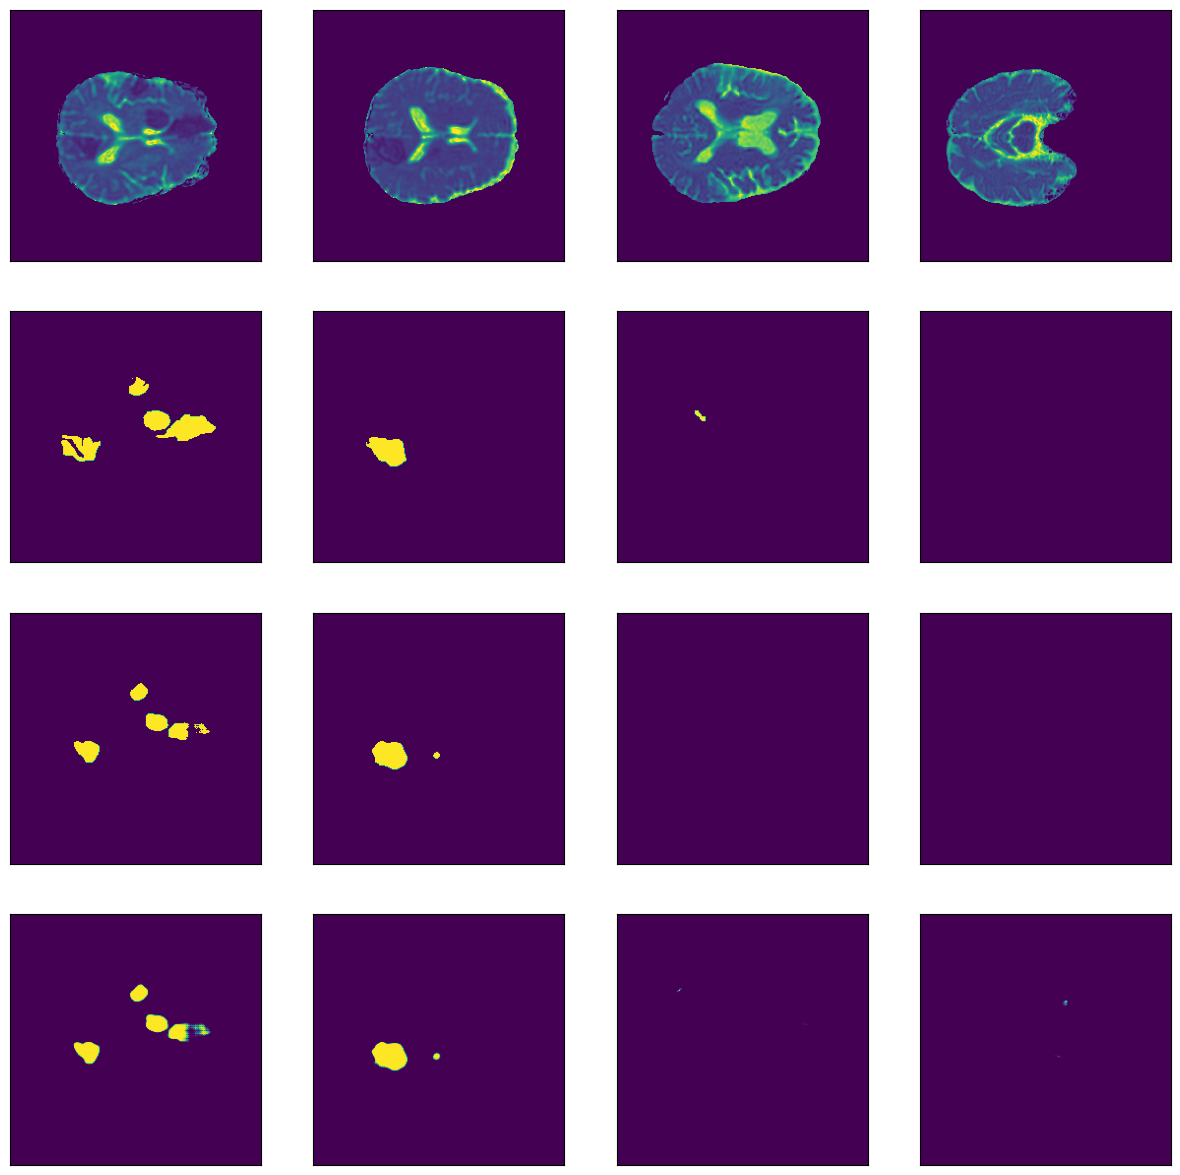

In [ ]:
ex_1 = 862
ex_2 = 514
ex_3 = 216
ex_4 =  50
plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(Xtest[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(Xtest[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(Xtest[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(Xtest[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(Ytest[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(Ytest[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(Ytest[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(Ytest[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

## **Métricas resultantes**

In [ ]:
metricas(Ytest, preds_val_t)


Accuracy: 0.9981316635289144 
Dice Score: 0.6466872696623642 
IoU: 0.47785501101509875


(0.6466872696623642, 0.9981316635289144, 0.47785501101509875)

## **Guardando el modelo**

In [ ]:
model.save("weights_unet_stroke.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **PARTE 2: SEGMENTACIÓN PARA MODALIDAD NCCT**

## **Cargar datos de train ADC**

In [ ]:
dataset_dir = Path("/content/drive/MyDrive/Project-IA2/APIS/train")
patients_dirs = sorted(dataset_dir.iterdir())

In [ ]:
epsilon = 1e-5
Xtrain=[]
Ytrain=[]

for patient_dir in tqdm(patients_dirs[0:]):
    patient_id = patient_dir.name
    print("Paciente: ",patient_id)
    content = sorted(patient_dir.iterdir())

    masks_dir = patient_dir / "masks" / f"{patient_id}_r1_mask.nii.gz"
    ncct_dir = patient_dir / f"{patient_id}_ncct.nii.gz"

    ncct = nib.load(ncct_dir)
    mask = nib.load(masks_dir)

    ncct = ncct.get_fdata()
    mask = mask.get_fdata()
    ncct = tf.image.resize(ncct, (256, 256), method="nearest")
    mask = tf.image.resize(mask, (256, 256), method="nearest")

    for i in range(2,ncct.shape[2]):
        normalized_ncct = (ncct[:,:,i]-np.min(ncct[:,:,i]))/(np.max(ncct[:,:,i]) - np.min(ncct[:,:,i]) + epsilon)
        Xtrain.append(normalized_ncct)
    print("Shape NCCT: ", ncct.shape)


    for i in range(2,ncct.shape[2]):
        Ytrain.append((mask[:,:,i]))
    print("Shape máscara: ", mask.shape)
    print("--------------------")

  0%|          | 0/60 [00:00<?, ?it/s]

Paciente:  train_000
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_001
Shape NCCT:  (256, 256, 23)
Shape máscara:  (256, 256, 23)
--------------------
Paciente:  train_002
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_003
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_004
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  train_005
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  train_006
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_007
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  train_008
Shape NCCT:  (256, 256, 20)
Shape máscara:  (256, 256, 20)
--------------------
Paciente:  train_009
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
-----------

In [ ]:
Xtrain = np.array(Xtrain)
Xtrain = Xtrain.reshape(-1, 256, 256, 1)
Ytrain = np.array(Ytrain)
print(Xtrain.shape)

(1361, 256, 256, 1)


## **Cargar datos de test NCCT**

In [ ]:
dataset_dir = Path("/content/drive/MyDrive/Project-IA2/APIS/test")
patients_dirs = sorted(dataset_dir.iterdir())

In [ ]:
Xtest = []
Ytest = []
epsilon = 1e-5

for patient_dir in tqdm(patients_dirs[0:]):
    patient_id = patient_dir.name
    print("Paciente: ", patient_id)
    content = sorted(patient_dir.iterdir())

    masks_dir = next(patient_dir.joinpath("masks").glob("*.nii.gz"))
    ncct_dir = patient_dir / f"{patient_id}_ncct.nii.gz"

    ncct = nib.load(ncct_dir)
    mask = nib.load(masks_dir)

    ncct = ncct.get_fdata()
    mask = mask.get_fdata()
    ncct = tf.image.resize(ncct, (256, 256), method="nearest")
    mask = tf.image.resize(mask, (256, 256), method="nearest")

    for i in range(2, ncct.shape[2]):
        normalized_ncct = (ncct[:,:,i]-np.min(ncct[:,:,i]))/(np.max(ncct[:,:,i]) - np.min(ncct[:,:,i]) + epsilon)
        Xtest.append(normalized_ncct)
    print("Shape NCCT: ", ncct.shape)

    for i in range(2, ncct.shape[2]):
        Ytest.append((mask[:, :, i]))
    print("Shape máscara: ", mask.shape)
    print("--------------------")

  0%|          | 0/38 [00:00<?, ?it/s]

Paciente:  test_000
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_001
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_002
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_003
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_004
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_005
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_006
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_007
Shape NCCT:  (256, 256, 26)
Shape máscara:  (256, 256, 26)
--------------------
Paciente:  test_008
Shape NCCT:  (256, 256, 24)
Shape máscara:  (256, 256, 24)
--------------------
Paciente:  test_009
Shape NCCT:  (256, 256, 23)
Shape máscara:  (256, 256, 23)
--------------------


In [ ]:
Xtest = np.array(Xtest)
Xtest = Xtest.reshape(-1, 256, 256, 1)
Ytest = np.array(Ytest)
print(Xtest.shape)

(873, 256, 256, 1)


## **Plotear algunas imágenes NCCT**

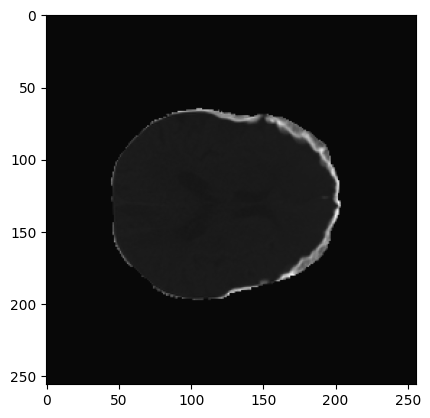

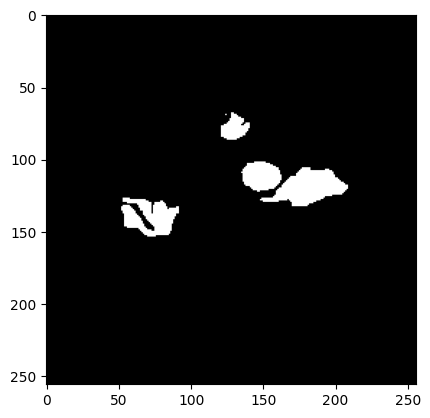

In [ ]:
plt.imshow(Xtest[862], cmap="gray")
plt.show(); plt.close()
plt.imshow(Ytest[862], cmap="gray")
plt.show(); plt.close()

Estas imágenes necesitan un preprocesamiento especial, el cual se denomina Windowing

## **Entrenamiento NCCT**

In [ ]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss=bce_dice_loss)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         640       ['img[0][0]']                 
                                                                                                  
 batch_normalization_19 (Ba  (None, 256, 256, 64)         256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_19

In [ ]:
results = model.fit(Xtrain, Ytrain, batch_size=32, epochs=50, shuffle=False, validation_split=0.1)

Epoch 1/50
39/39 [==============================] - 117s 2s/step - loss: 1.1891 - val_loss: 1.2671
Epoch 2/50
39/39 [==============================] - 63s 2s/step - loss: 1.0548 - val_loss: 1.1977
Epoch 3/50
39/39 [==============================] - 63s 2s/step - loss: 1.0339 - val_loss: 1.1315
Epoch 4/50
39/39 [==============================] - 63s 2s/step - loss: 1.0241 - val_loss: 1.0687
Epoch 5/50
39/39 [==============================] - 63s 2s/step - loss: 1.0188 - val_loss: 1.0508
Epoch 6/50
39/39 [==============================] - 63s 2s/step - loss: 1.0148 - val_loss: 1.0325
Epoch 7/50
39/39 [==============================] - 63s 2s/step - loss: 1.0124 - val_loss: 1.0331
Epoch 8/50
39/39 [==============================] - 63s 2s/step - loss: 1.0104 - val_loss: 1.0186
Epoch 9/50
39/39 [==============================] - 63s 2s/step - loss: 1.0090 - val_loss: 1.0097
Epoch 10/50
39/39 [==============================] - 63s 2s/step - loss: 1.0085 - val_loss: 1.0137
Epoch 11/50
39/39 

In [ ]:
preds_train = model.predict(Xtrain, verbose=1)
preds_val = model.predict(Xtest, verbose=1)

preds_val.shape, preds_train.shape

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

28/28 [==============================] - 11s 390ms/step


## **Visualizando predicciones NCCT**

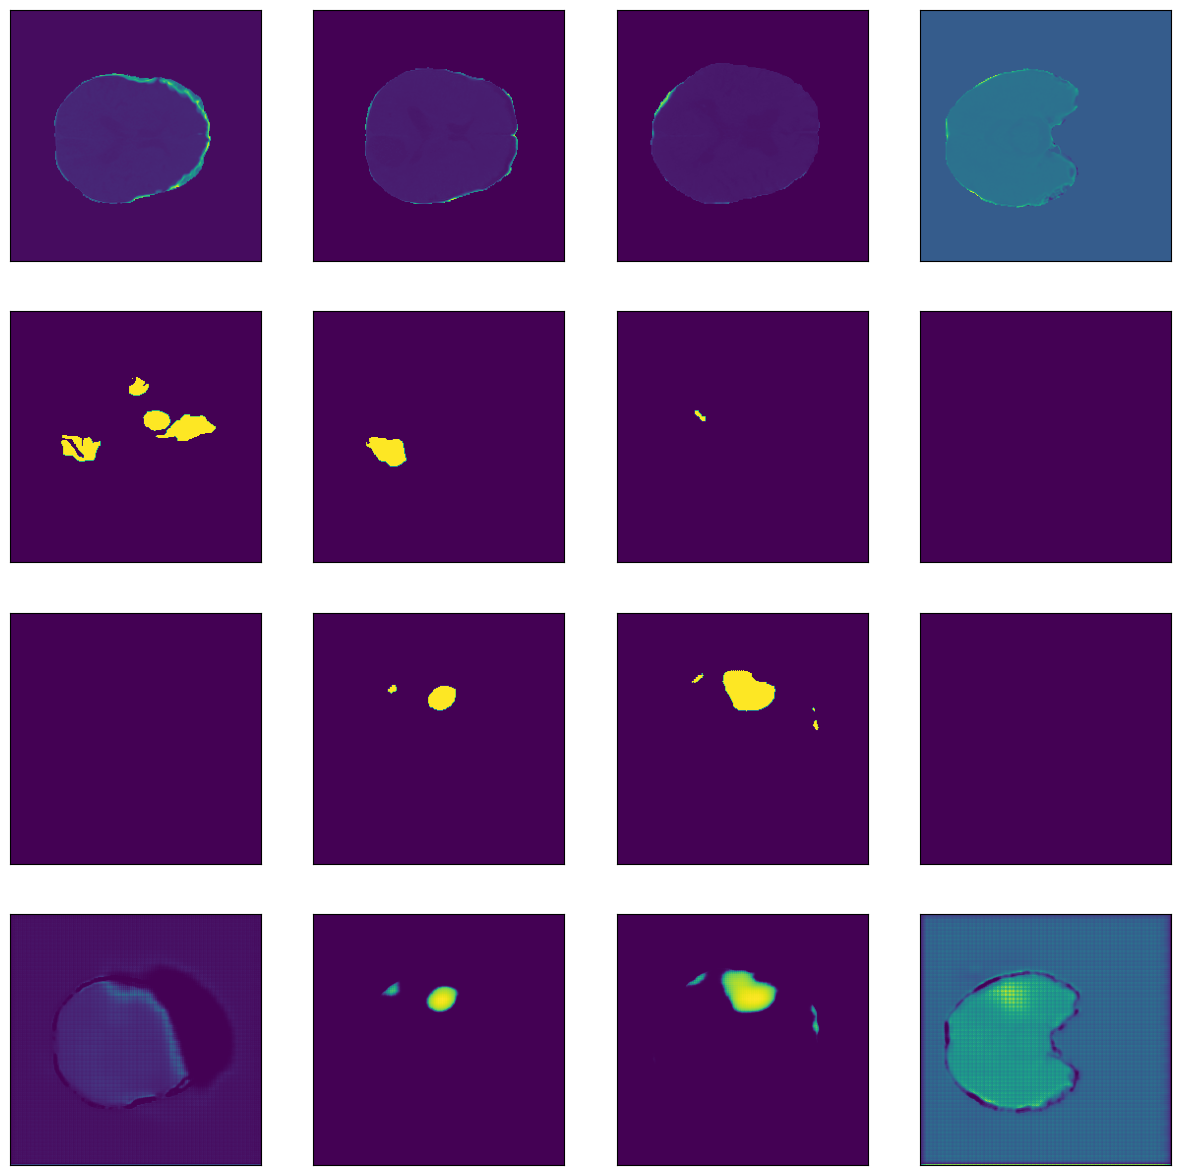

In [ ]:
ex_1 = 862
ex_2 = 514
ex_3 = 216
ex_4 =  50
plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(Xtest[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(Xtest[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(Xtest[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(Xtest[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(Ytest[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(Ytest[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(Ytest[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(Ytest[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

## **Métricas resultantes**

In [ ]:
metricas(Ytest, preds_val_t)

Accuracy: 0.9957483385573275 
Dice Score: 0.03106950806612229 
IoU: 0.01577989075460247


(0.03106950806612229, 0.9957483385573275, 0.01577989075460247)

## **Guardando el modelo**

In [ ]:
model.save("weights_unet_stroke_NCCT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
